In [1]:
%precision 3
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spla
# the following allows us to plot triangles indicating convergence order
from matplotlib import cm
# and we will create some animations!
import matplotlib.animation as animation
from IPython.display import HTML
from pprint import pprint

In [2]:
def pressure_poisson_jacobi(p, dx, dy, RHS, rtol = 1.e-5, logs = False):
    """ Solve the pressure Poisson equation (PPE)
    using Jacobi iteration assuming mesh spacing of
    dx and dy (we assume at the moment that dx=dy)
    and the RHS function given by RHS.
    
    Assumes imposition of a Neumann BC on all boundaries.
    
    Return the pressure field.
    """
    # our code below is only currently for the case dx=dy
    assert dx==dy
    # iterate
    tol = 10.*rtol
    it = 0
    p_old = np.copy(p)
    while tol > rtol:
        #swap arrays without copying the data
        temp = p_old
        p_old = p
        p = temp
        
        it += 1
        p[1:-1, 1:-1] = 0.25*(p_old[2:, 1:-1] + p_old[:-2, 1:-1] +
                                p_old[1:-1, 2:] + p_old[1:-1,:-2]
                                - (dx**2)*RHS[1:-1, 1:-1])
        
        # apply zero gradient Neumann boundary conditions at the walls
        # CHECKPOINT
        p[0, :] = p[1, :]
        p[-1, :] = p[-2, :]
        p[:, 0] = p[:, 1]
        p[:, -1] = p[:, -2]
        # fix pressure level - choose an arbitrary node to set p to
        # be zero, avoid the corners and set it to an interior location
        p[1,1] = 0

        # relative change in pressure
        tol = sl.norm(p - p_old)/np.maximum(1.0e-10,sl.norm(p))
        
    if logs: print('pressure solve iterations = {:4d}'.format(it))
    return p

In [3]:
def calculate_ppm_RHS(rho, u, v, RHS, dt, dx, dy):
    """ Calculate the RHS of the 
    Poisson equation resulting from the projection method.
    Use central differences for the first derivatives of u and v.
    """
    RHS[1:-1, 1:-1] = rho * (
        (1.0/dt) * ( (u[2:, 1:-1] - u[:-2, 1:-1]) / (2*dx) 
                   + (v[1:-1, 2:] - v[1:-1, :-2]) / (2*dy) )
        )
    return RHS


def project_velocity(rho, u, v, dt, dx, dy, p):
    """ Update the velocity to be divergence free using the pressure.
    """
    u[1:-1, 1:-1] = u[1:-1, 1:-1] - dt * (1./rho) * (
        (p[2:, 1:-1] - p[:-2, 1:-1])/(2*dx) )
    v[1:-1, 1:-1] = v[1:-1, 1:-1] - dt * (1./rho) * (
        (p[1:-1, 2:] - p[1:-1, :-2])/(2*dy) )    
    return u, v

def calculate_intermediate_velocity(nu, u, v, u_old, v_old, dt, dx, dy):
    """ Calculate the intermediate velocities.
    """
    # intermediate u
    u[1:-1, 1:-1] = u_old[1:-1, 1:-1] - dt * (
                      # ADVECTION:  uu_x + vu_x
                        u_old[1:-1, 1:-1] *
                      # see comments in the upwind based solver for advection above
                      np.select([u_old[1:-1, 1:-1] > 0, u_old[1:-1, 1:-1] < 0],
                      [np.diff(u_old[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(u_old[1:, 1:-1], n=1, axis=0)/dx]) +
                             v_old[1:-1, 1:-1] *
                       np.select([v_old[1:-1, 1:-1] > 0, v_old[1:-1, 1:-1] < 0],
                      [np.diff(u_old[1:-1, :-1], n=1, axis=1)/dy,
                       np.diff(u_old[1:-1, 1:], n=1, axis=1)/dy]) ) + (
                       # DIFFUSION
                         dt*nu*(np.diff(u_old[:, 1:-1], n=2, axis=0)/(dx**2)
                                 + np.diff(u_old[1:-1, :], n=2, axis=1)/(dy**2)) )
    # intermediate v
    v[1:-1, 1:-1] = v_old[1:-1, 1:-1] - dt * (
                      # ADVECTION:  uv_x + vv_x
                        u_old[1:-1, 1:-1] *
                      np.select([u_old[1:-1, 1:-1] > 0, u_old[1:-1, 1:-1] < 0],
                      [np.diff(v_old[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(v_old[1:, 1:-1], n=1, axis=0)/dx]) +
                             v_old[1:-1, 1:-1] *
                       np.select([v_old[1:-1, 1:-1] > 0, v_old[1:-1, 1:-1] < 0],
                      [np.diff(v_old[1:-1, :-1], n=1, axis=1)/dy,
                       np.diff(v_old[1:-1, 1:], n=1, axis=1)/dy]) ) + (
                       # DIFFUSION
                        dt*nu*(np.diff(v_old[:, 1:-1], n=2, axis=0)/(dx**2)
                                 + np.diff(v_old[1:-1, :], n=2, axis=1)/(dy**2)) )
    return u, v

In [4]:
def solve_NS(u, v, p, rho, nu, dt, t_end, dx, dy, rtol = 1.e-5, logs = False):
    """ Solve the incompressible Navier-Stokes equations
    using a lot of the numerical choices and approaches we've seen
    earlier in this lecture.
    """
    t = 0
    
    u_old = u.copy()
    v_old = v.copy()
    p_RHS = np.zeros_like(X)
    
    while t < t_end:
        t += dt
        if logs: print('\nTime = {:.8f}'.format(t))
            
        # calculate intermediate velocities
        u, v = calculate_intermediate_velocity(nu, u, v, u_old, v_old, dt, dx, dy)
        # PPM
        # calculate RHS for the pressure Poisson problem
        p_RHS = calculate_ppm_RHS(rho, u, v, p_RHS, dt, dx, dy)
        # compute pressure - note that we use the previous p as an initial guess to the solution
        p = pressure_poisson_jacobi(p, dx, dy, p_RHS, 1.e-5, logs)
        # project velocity
        u, v = project_velocity(rho, u, v, dt, dx, dy, p)
        
        if logs:
            print('norm(u) = {0:.8f}, norm(v) = {1:.8f}'.format(sl.norm(u),sl.norm(v)))
            print('Courant number: {0:.8f}'.format(np.max(np.sqrt(u**2+v**2)) * dt / dx ))
        
        # relative change in u and v
        tolu = sl.norm(u - u_old)/np.maximum(1.0e-10,sl.norm(u))
        tolv = sl.norm(v - v_old)/np.maximum(1.0e-10,sl.norm(v))
        if tolu < rtol and tolv < rtol: break
        
        #swap pointers without copying data
        temp = u_old
        u_old = u
        u = temp
        temp = v_old
        v_old = v
        v = temp
    return u, v, p

In [5]:
# physical parameters
rho = 1
nu = 1./10.

# define spatial mesh
# Size of rectangular domain
Lx = 1
Ly = Lx

# Number of grid points in each direction, including boundary nodes
Nx = 51
Ny = Nx

# hence the mesh spacing
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

# read the docs to see the ordering that mgrid gives us
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx*X
Y = dy*Y
# the following is an alternative to the three lines above
#X, Y = np.mgrid[0: Lx + 1e-10: dx, 0: Ly + 1e-10: dy]
# but without the need to add a "small" increement to ensure
# the Lx and Ly end points are included

# time stepping parameters
dt = 2.e-4
t_end = 2.0

# initialise independent variables
u = np.zeros_like(X)
v = np.zeros_like(X)
p = np.zeros_like(X)

# CHECKPOINT
# Apply Dirichlet BCs to u and v - the code below doesn't touch 
# these so we can do this once outside the time loop
u[:, -1]=1  # set velocity on cavity lid equal to 1
u[:, 0]=0
u[0, :]=0
u[-1, :]=0
v[:, -1]=0
v[:, 0]=0
v[0, :]=0
v[-1, :]=0

import time
start = time.time()
u, v, p = solve_NS(u, v, p, rho, nu, dt, t_end, dx, dy, rtol=1.e-6, logs = True)
end = time.time()
print('Time taken by calculation = ', end - start)


Time = 0.00020000
pressure solve iterations = 6287
norm(u) = 7.00800116, norm(v) = 0.03434455
Courant number: 0.01000000

Time = 0.00040000
pressure solve iterations = 11646
norm(u) = 7.02817911, norm(v) = 0.08291610
Courant number: 0.01000000

Time = 0.00060000
pressure solve iterations = 5095
norm(u) = 7.05640282, norm(v) = 0.13825832
Courant number: 0.01000000

Time = 0.00080000
pressure solve iterations = 2804
norm(u) = 7.08992394, norm(v) = 0.19662819
Courant number: 0.01000000

Time = 0.00100000
pressure solve iterations = 1746
norm(u) = 7.12685793, norm(v) = 0.25592215
Courant number: 0.01000000

Time = 0.00120000
pressure solve iterations =  857
norm(u) = 7.16589598, norm(v) = 0.31489018
Courant number: 0.01000000

Time = 0.00140000
pressure solve iterations =   59
norm(u) = 7.20612151, norm(v) = 0.37280127
Courant number: 0.01000000

Time = 0.00160000
pressure solve iterations =  178
norm(u) = 7.24687945, norm(v) = 0.42942124
Courant number: 0.01000000

Time = 0.00180000
pres

pressure solve iterations =  310
norm(u) = 8.96166324, norm(v) = 2.23113033
Courant number: 0.01000000

Time = 0.01680000
pressure solve iterations =  305
norm(u) = 8.97453980, norm(v) = 2.24402582
Courant number: 0.01000000

Time = 0.01700000
pressure solve iterations =  300
norm(u) = 8.98729127, norm(v) = 2.25681008
Courant number: 0.01000000

Time = 0.01720000
pressure solve iterations =  296
norm(u) = 8.99991999, norm(v) = 2.26948521
Courant number: 0.01000000

Time = 0.01740000
pressure solve iterations =  291
norm(u) = 9.01242822, norm(v) = 2.28205342
Courant number: 0.01000000

Time = 0.01760000
pressure solve iterations =  287
norm(u) = 9.02481817, norm(v) = 2.29451669
Courant number: 0.01000000

Time = 0.01780000
pressure solve iterations =  283
norm(u) = 9.03709199, norm(v) = 2.30687700
Courant number: 0.01000000

Time = 0.01800000
pressure solve iterations =  278
norm(u) = 9.04925175, norm(v) = 2.31913640
Courant number: 0.01000000

Time = 0.01820000
pressure solve iteration

pressure solve iterations =  116
norm(u) = 9.74987319, norm(v) = 3.05539989
Courant number: 0.01000000

Time = 0.03360000
pressure solve iterations =  115
norm(u) = 9.75682308, norm(v) = 3.06306152
Courant number: 0.01000000

Time = 0.03380000
pressure solve iterations =  113
norm(u) = 9.76373345, norm(v) = 3.07068795
Courant number: 0.01000000

Time = 0.03400000
pressure solve iterations =  113
norm(u) = 9.77060475, norm(v) = 3.07827936
Courant number: 0.01000000

Time = 0.03420000
pressure solve iterations =  111
norm(u) = 9.77743734, norm(v) = 3.08583623
Courant number: 0.01000000

Time = 0.03440000
pressure solve iterations =  111
norm(u) = 9.78423164, norm(v) = 3.09335875
Courant number: 0.01000000

Time = 0.03460000
pressure solve iterations =  110
norm(u) = 9.79098804, norm(v) = 3.10084729
Courant number: 0.01000000

Time = 0.03480000
pressure solve iterations =  108
norm(u) = 9.79770687, norm(v) = 3.10830229
Courant number: 0.01000000

Time = 0.03500000
pressure solve iteration

pressure solve iterations =   63
norm(u) = 10.21604757, norm(v) = 3.58977035
Courant number: 0.01000000

Time = 0.05000000
pressure solve iterations =   61
norm(u) = 10.22070643, norm(v) = 3.59534339
Courant number: 0.01000000

Time = 0.05020000
pressure solve iterations =   61
norm(u) = 10.22534566, norm(v) = 3.60089806
Courant number: 0.01000000

Time = 0.05040000
pressure solve iterations =   62
norm(u) = 10.22996546, norm(v) = 3.60643433
Courant number: 0.01000000

Time = 0.05060000
pressure solve iterations =   60
norm(u) = 10.23456589, norm(v) = 3.61195255
Courant number: 0.01000000

Time = 0.05080000
pressure solve iterations =   60
norm(u) = 10.23914711, norm(v) = 3.61745275
Courant number: 0.01000000

Time = 0.05100000
pressure solve iterations =   60
norm(u) = 10.24370929, norm(v) = 3.62293501
Courant number: 0.01000000

Time = 0.05120000
pressure solve iterations =   59
norm(u) = 10.24825251, norm(v) = 3.62839951
Courant number: 0.01000000

Time = 0.05140000
pressure solve i

pressure solve iterations =   26
norm(u) = 10.80729230, norm(v) = 4.34432466
Courant number: 0.01000000

Time = 0.08420000
pressure solve iterations =   26
norm(u) = 10.80986766, norm(v) = 4.34785399
Courant number: 0.01000000

Time = 0.08440000
pressure solve iterations =   26
norm(u) = 10.81243553, norm(v) = 4.35137546
Courant number: 0.01000000

Time = 0.08460000
pressure solve iterations =   26
norm(u) = 10.81499593, norm(v) = 4.35488910
Courant number: 0.01000000

Time = 0.08480000
pressure solve iterations =   25
norm(u) = 10.81754886, norm(v) = 4.35839503
Courant number: 0.01000000

Time = 0.08500000
pressure solve iterations =   25
norm(u) = 10.82009438, norm(v) = 4.36189326
Courant number: 0.01000000

Time = 0.08520000
pressure solve iterations =   26
norm(u) = 10.82263255, norm(v) = 4.36538370
Courant number: 0.01000000

Time = 0.08540000
pressure solve iterations =   25
norm(u) = 10.82516337, norm(v) = 4.36886648
Courant number: 0.01000000

Time = 0.08560000
pressure solve i

pressure solve iterations =   10
norm(u) = 11.36580372, norm(v) = 5.17938006
Courant number: 0.01000000

Time = 0.14760000
pressure solve iterations =    9
norm(u) = 11.36699988, norm(v) = 5.18135254
Courant number: 0.01000000

Time = 0.14780000
pressure solve iterations =   10
norm(u) = 11.36819359, norm(v) = 5.18332185
Courant number: 0.01000000

Time = 0.14800000
pressure solve iterations =    9
norm(u) = 11.36938481, norm(v) = 5.18528810
Courant number: 0.01000000

Time = 0.14820000
pressure solve iterations =    9
norm(u) = 11.37057356, norm(v) = 5.18725128
Courant number: 0.01000000

Time = 0.14840000
pressure solve iterations =   10
norm(u) = 11.37175988, norm(v) = 5.18921131
Courant number: 0.01000000

Time = 0.14860000
pressure solve iterations =    9
norm(u) = 11.37294374, norm(v) = 5.19116830
Courant number: 0.01000000

Time = 0.14880000
pressure solve iterations =    9
norm(u) = 11.37412514, norm(v) = 5.19312223
Courant number: 0.01000000

Time = 0.14900000
pressure solve i

pressure solve iterations =    4
norm(u) = 11.74767966, norm(v) = 5.87120538
Courant number: 0.01000000

Time = 0.24560000
pressure solve iterations =    3
norm(u) = 11.74817113, norm(v) = 5.87219901
Courant number: 0.01000000

Time = 0.24580000
pressure solve iterations =    3
norm(u) = 11.74866178, norm(v) = 5.87319139
Courant number: 0.01000000

Time = 0.24600000
pressure solve iterations =    3
norm(u) = 11.74915162, norm(v) = 5.87418252
Courant number: 0.01000000

Time = 0.24620000
pressure solve iterations =    4
norm(u) = 11.74964069, norm(v) = 5.87517233
Courant number: 0.01000000

Time = 0.24640000
pressure solve iterations =    3
norm(u) = 11.75012894, norm(v) = 5.87616091
Courant number: 0.01000000

Time = 0.24660000
pressure solve iterations =    3
norm(u) = 11.75061639, norm(v) = 5.87714823
Courant number: 0.01000000

Time = 0.24680000
pressure solve iterations =    4
norm(u) = 11.75110307, norm(v) = 5.87813425
Courant number: 0.01000000

Time = 0.24700000
pressure solve i

pressure solve iterations =    1
norm(u) = 11.94267216, norm(v) = 6.30076897
Courant number: 0.01000000

Time = 0.36900000
pressure solve iterations =    1
norm(u) = 11.94286494, norm(v) = 6.30123986
Courant number: 0.01000000

Time = 0.36920000
pressure solve iterations =    2
norm(u) = 11.94305747, norm(v) = 6.30171015
Courant number: 0.01000000

Time = 0.36940000
pressure solve iterations =    1
norm(u) = 11.94324971, norm(v) = 6.30217991
Courant number: 0.01000000

Time = 0.36960000
pressure solve iterations =    1
norm(u) = 11.94344167, norm(v) = 6.30264914
Courant number: 0.01000000

Time = 0.36980000
pressure solve iterations =    1
norm(u) = 11.94363336, norm(v) = 6.30311784
Courant number: 0.01000000

Time = 0.37000000
pressure solve iterations =    1
norm(u) = 11.94382477, norm(v) = 6.30358601
Courant number: 0.01000000

Time = 0.37020000
pressure solve iterations =    2
norm(u) = 11.94401593, norm(v) = 6.30405359
Courant number: 0.01000000

Time = 0.37040000
pressure solve i

pressure solve iterations =    1
norm(u) = 12.02351986, norm(v) = 6.51170214
Courant number: 0.01000000

Time = 0.49440000
pressure solve iterations =    1
norm(u) = 12.02360192, norm(v) = 6.51193352
Courant number: 0.01000000

Time = 0.49460000
pressure solve iterations =    1
norm(u) = 12.02368388, norm(v) = 6.51216465
Courant number: 0.01000000

Time = 0.49480000
pressure solve iterations =    1
norm(u) = 12.02376573, norm(v) = 6.51239552
Courant number: 0.01000000

Time = 0.49500000
pressure solve iterations =    1
norm(u) = 12.02384747, norm(v) = 6.51262613
Courant number: 0.01000000

Time = 0.49520000
pressure solve iterations =    1
norm(u) = 12.02392911, norm(v) = 6.51285649
Courant number: 0.01000000

Time = 0.49540000
pressure solve iterations =    1
norm(u) = 12.02401064, norm(v) = 6.51308659
Courant number: 0.01000000

Time = 0.49560000
pressure solve iterations =    1
norm(u) = 12.02409207, norm(v) = 6.51331643
Courant number: 0.01000000

Time = 0.49580000
pressure solve i

pressure solve iterations =    1
norm(u) = 12.05987096, norm(v) = 6.61944209
Courant number: 0.01000000

Time = 0.62500000
pressure solve iterations =    1
norm(u) = 12.05990693, norm(v) = 6.61955498
Courant number: 0.01000000

Time = 0.62520000
pressure solve iterations =    1
norm(u) = 12.05994285, norm(v) = 6.61966775
Courant number: 0.01000000

Time = 0.62540000
pressure solve iterations =    1
norm(u) = 12.05997872, norm(v) = 6.61978039
Courant number: 0.01000000

Time = 0.62560000
pressure solve iterations =    1
norm(u) = 12.06001456, norm(v) = 6.61989292
Courant number: 0.01000000

Time = 0.62580000
pressure solve iterations =    1
norm(u) = 12.06005034, norm(v) = 6.62000532
Courant number: 0.01000000

Time = 0.62600000
pressure solve iterations =    1
norm(u) = 12.06008609, norm(v) = 6.62011760
Courant number: 0.01000000

Time = 0.62620000
pressure solve iterations =    1
norm(u) = 12.06012179, norm(v) = 6.62022976
Courant number: 0.01000000

Time = 0.62640000
pressure solve i

pressure solve iterations =    1
norm(u) = 12.07627274, norm(v) = 6.67274839
Courant number: 0.01000000

Time = 0.75720000
pressure solve iterations =    1
norm(u) = 12.07628909, norm(v) = 6.67280363
Courant number: 0.01000000

Time = 0.75740000
pressure solve iterations =    1
norm(u) = 12.07630541, norm(v) = 6.67285880
Courant number: 0.01000000

Time = 0.75760000
pressure solve iterations =    1
norm(u) = 12.07632172, norm(v) = 6.67291392
Courant number: 0.01000000

Time = 0.75780000
pressure solve iterations =    1
norm(u) = 12.07633800, norm(v) = 6.67296898
Courant number: 0.01000000

Time = 0.75800000
pressure solve iterations =    1
norm(u) = 12.07635427, norm(v) = 6.67302398
Courant number: 0.01000000

Time = 0.75820000
pressure solve iterations =    1
norm(u) = 12.07637052, norm(v) = 6.67307892
Courant number: 0.01000000

Time = 0.75840000
pressure solve iterations =    1
norm(u) = 12.07638675, norm(v) = 6.67313380
Courant number: 0.01000000

Time = 0.75860000
pressure solve i

pressure solve iterations =    1
norm(u) = 12.08364392, norm(v) = 6.69822304
Courant number: 0.01000000

Time = 0.88440000
pressure solve iterations =    1
norm(u) = 12.08365181, norm(v) = 6.69825098
Courant number: 0.01000000

Time = 0.88460000
pressure solve iterations =    1
norm(u) = 12.08365969, norm(v) = 6.69827889
Courant number: 0.01000000

Time = 0.88480000
pressure solve iterations =    1
norm(u) = 12.08366756, norm(v) = 6.69830677
Courant number: 0.01000000

Time = 0.88500000
pressure solve iterations =    1
norm(u) = 12.08367542, norm(v) = 6.69833462
Courant number: 0.01000000

Time = 0.88520000
pressure solve iterations =    1
norm(u) = 12.08368327, norm(v) = 6.69836244
Courant number: 0.01000000

Time = 0.88540000
pressure solve iterations =    1
norm(u) = 12.08369111, norm(v) = 6.69839023
Courant number: 0.01000000

Time = 0.88560000
pressure solve iterations =    1
norm(u) = 12.08369895, norm(v) = 6.69841799
Courant number: 0.01000000

Time = 0.88580000
pressure solve i

pressure solve iterations =    1
norm(u) = 12.08721938, norm(v) = 6.71107428
Courant number: 0.01000000

Time = 1.01080000
pressure solve iterations =    1
norm(u) = 12.08722328, norm(v) = 6.71108852
Courant number: 0.01000000

Time = 1.01100000
pressure solve iterations =    1
norm(u) = 12.08722718, norm(v) = 6.71110275
Courant number: 0.01000000

Time = 1.01120000
pressure solve iterations =    1
norm(u) = 12.08723107, norm(v) = 6.71111696
Courant number: 0.01000000

Time = 1.01140000
pressure solve iterations =    1
norm(u) = 12.08723495, norm(v) = 6.71113116
Courant number: 0.01000000

Time = 1.01160000
pressure solve iterations =    1
norm(u) = 12.08723884, norm(v) = 6.71114534
Courant number: 0.01000000

Time = 1.01180000
pressure solve iterations =    1
norm(u) = 12.08724272, norm(v) = 6.71115951
Courant number: 0.01000000

Time = 1.01200000
pressure solve iterations =    1
norm(u) = 12.08724659, norm(v) = 6.71117367
Courant number: 0.01000000

Time = 1.01220000
pressure solve i

pressure solve iterations =    1
norm(u) = 12.08900769, norm(v) = 6.71766981
Courant number: 0.01000000

Time = 1.13820000
pressure solve iterations =    1
norm(u) = 12.08900963, norm(v) = 6.71767705
Courant number: 0.01000000

Time = 1.13840000
pressure solve iterations =    1
norm(u) = 12.08901157, norm(v) = 6.71768428
Courant number: 0.01000000

Time = 1.13860000
pressure solve iterations =    1
norm(u) = 12.08901351, norm(v) = 6.71769150
Courant number: 0.01000000

Time = 1.13880000
pressure solve iterations =    1
norm(u) = 12.08901544, norm(v) = 6.71769872
Courant number: 0.01000000

Time = 1.13900000
pressure solve iterations =    1
norm(u) = 12.08901738, norm(v) = 6.71770593
Courant number: 0.01000000

Time = 1.13920000
pressure solve iterations =    1
norm(u) = 12.08901931, norm(v) = 6.71771313
Courant number: 0.01000000

Time = 1.13940000
pressure solve iterations =    1
norm(u) = 12.08902124, norm(v) = 6.71772033
Courant number: 0.01000000

Time = 1.13960000
pressure solve i

In [6]:
# benchmark data from
# MARCHI, Carlos Henrique; SUERO, Roberta  and  ARAKI, Luciano Kiyoshi. 
# The lid-driven square cavity flow: numerical solution with a 
# 1024 x 1024 grid. 
# J. Braz. Soc. Mech. Sci. & Eng. 2009, vol.31, n.3, pp.186-198.  
# http://dx.doi.org/10.1590/S1678-58782009000300004.

Marchi_Re10_u = np.array([[0.0625, -3.85425800e-2],
                          [0.125,  -6.96238561e-2],
                          [0.1875, -9.6983962e-2],
                          [0.25,  -1.22721979e-1],
                          [0.3125, -1.47636199e-1],
                          [0.375,  -1.71260757e-1],
                          [0.4375, -1.91677043e-1],
                          [0.5,    -2.05164738e-1],
                          [0.5625, -2.05770198e-1],
                          [0.625,  -1.84928116e-1],
                          [0.6875, -1.313892353e-1],
                          [0.75,   -3.1879308e-2],
                          [0.8125,  1.26912095e-1],
                          [0.875,   3.54430364e-1],
                          [0.9375,  6.50529292e-1]])

Marchi_Re10_v = np.array([[0.0625, 9.2970121e-2],
                          [0.125, 1.52547843e-1],
                          [0.1875, 1.78781456e-1],
                          [0.25, 1.76415100e-1],
                          [0.3125, 1.52055820e-1],
                          [0.375, 1.121477612e-1],
                          [0.4375, 6.21048147e-2],
                          [0.5, 6.3603620e-3],
                          [0.5625, -5.10417285e-2],
                          [0.625, -1.056157259e-1],
                          [0.6875, -1.51622101e-1],
                          [0.75, -1.81633561e-1],
                          [0.8125, -1.87021651e-1],
                          [0.875, -1.59898186e-1],
                          [0.9375, -9.6409942e-2]])

Text(0.5, 1.0, 'Lid driven cavity - comparison with data')

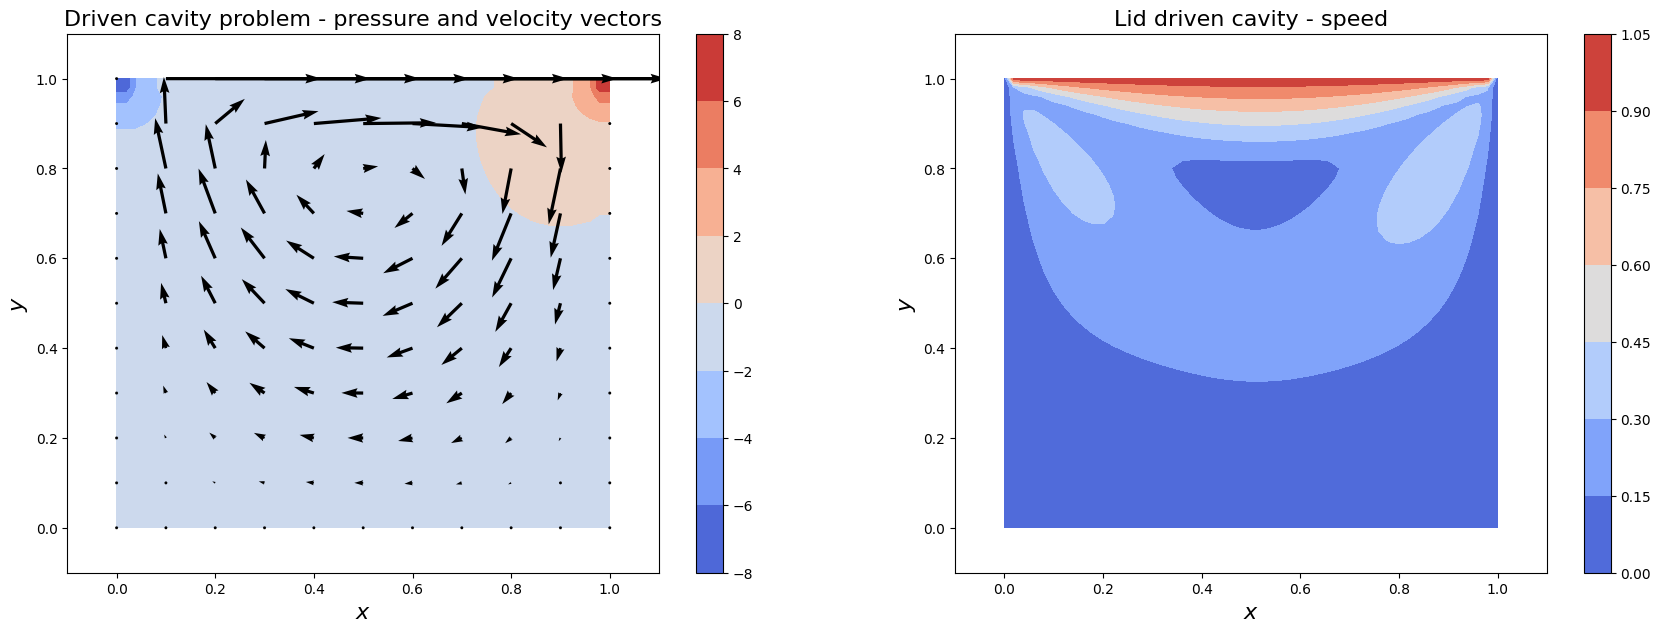

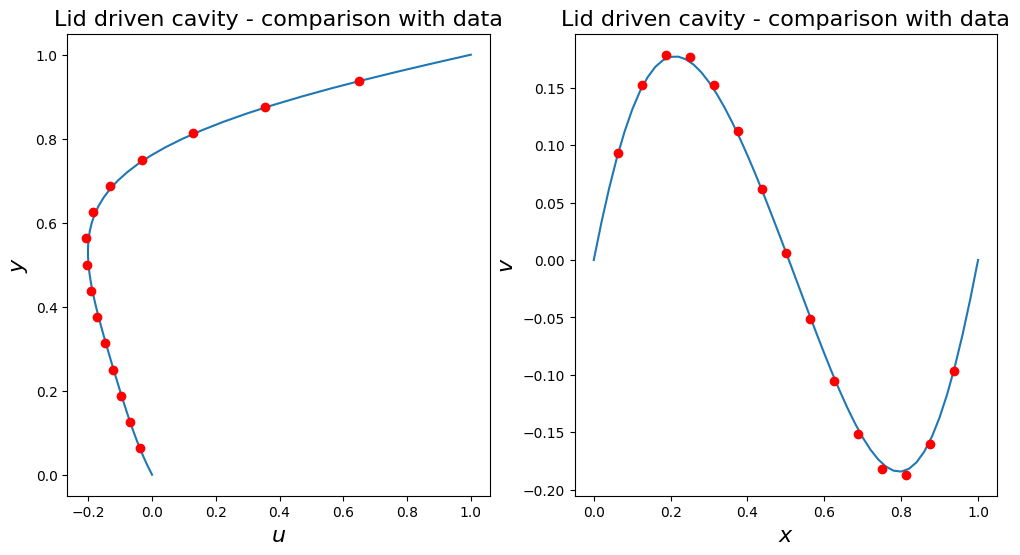

In [7]:
# set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X,Y,p, cmap=cm.coolwarm)
fig.colorbar(cont)
# don't plot at every gird point - every 5th
ax1.quiver(X[::5,::5],Y[::5,::5],u[::5,::5],v[::5,::5])
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Driven cavity problem - pressure and velocity vectors', fontsize=16)

ax1 = fig.add_subplot(122)
cont = ax1.contourf(X,Y,np.sqrt(u*u+v*v), cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Lid driven cavity - speed', fontsize=16)


fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.plot(u[int(np.shape(u)[0]/2),:],Y[int(np.shape(u)[0]/2),:])
ax1.plot(Marchi_Re10_u[:,1],Marchi_Re10_u[:,0],'ro')
ax1.set_xlabel('$u$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Lid driven cavity - comparison with data', fontsize=16)
ax1 = fig.add_subplot(122)
ax1.plot(X[:,int(np.shape(u)[0]/2)],v[:,int(np.shape(u)[0]/2)])
ax1.plot(Marchi_Re10_v[:,0],Marchi_Re10_v[:,1],'ro')
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$v$', fontsize=16)
ax1.set_title('Lid driven cavity - comparison with data', fontsize=16)

In [8]:
# physical parameters (Re=100)
rho = 1
nu = 1./100.

# define spatial mesh
# Size of rectangular domain
Lx = 1
Ly = Lx

# Number of grid points in each direction, including boundary nodes
Nx = 51
Ny = Nx

# hence the mesh spacing
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

# read the docs to see the ordering that mgrid gives us
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx*X
Y = dy*Y
# the following is an alternative to the three lines above
#X, Y = np.mgrid[0: Lx + 1e-10: dx, 0: Ly + 1e-10: dy]
# but without the need to add a "small" increement to ensure
# the Lx and Ly end points are included

# time stepping parameters
dt = 1.e-3
t_end = 20.0

# initialise independent variables
u = np.zeros_like(X)
v = np.zeros_like(X)
p = np.zeros_like(X)



# CHECKPOINT
# Apply Dirichlet BCs to u and v - the code below doesn't touch 
# these so we can do this once outside the time loop
u[:, -1]=1  # set velocity on cavity lid equal to 1
u[:, 0]=0
u[0, :]=0
u[-1, :]=0
v[:, -1]=0
v[:, 0]=0
v[0, :]=0
v[-1, :]=0

import time
start = time.time()
u, v, p = solve_NS(u, v, p, rho, nu, dt, t_end, dx, dy, rtol=1.e-6, logs = True)
end = time.time()
print('Time taken by calculation = ', end - start)


Time = 0.00100000
pressure solve iterations = 6287
norm(u) = 7.00200115, norm(v) = 0.01717228
Courant number: 0.05000000

Time = 0.00200000
pressure solve iterations = 10414
norm(u) = 7.00745138, norm(v) = 0.04178818
Courant number: 0.05000000

Time = 0.00300000
pressure solve iterations = 3376
norm(u) = 7.01571186, norm(v) = 0.07040052
Courant number: 0.05000000

Time = 0.00400000
pressure solve iterations = 2237
norm(u) = 7.02629300, norm(v) = 0.10129465
Courant number: 0.05000000

Time = 0.00500000
pressure solve iterations = 1610
norm(u) = 7.03879842, norm(v) = 0.13348771
Courant number: 0.05000000

Time = 0.00600000
pressure solve iterations = 1277
norm(u) = 7.05289950, norm(v) = 0.16636954
Courant number: 0.05000000

Time = 0.00700000
pressure solve iterations = 1692
norm(u) = 7.06832007, norm(v) = 0.19955296
Courant number: 0.05000000

Time = 0.00800000
pressure solve iterations = 13659
norm(u) = 7.08482681, norm(v) = 0.23281611
Courant number: 0.05000000

Time = 0.00900000
pre

pressure solve iterations =  994
norm(u) = 8.15305592, norm(v) = 1.51719629
Courant number: 0.05000000

Time = 0.07400000
pressure solve iterations =  956
norm(u) = 8.16490768, norm(v) = 1.52899292
Courant number: 0.05000000

Time = 0.07500000
pressure solve iterations =  921
norm(u) = 8.17665272, norm(v) = 1.54066809
Courant number: 0.05000000

Time = 0.07600000
pressure solve iterations =  886
norm(u) = 8.18829279, norm(v) = 1.55222447
Courant number: 0.05000000

Time = 0.07700000
pressure solve iterations =  851
norm(u) = 8.19982958, norm(v) = 1.56366459
Courant number: 0.05000000

Time = 0.07800000
pressure solve iterations =  820
norm(u) = 8.21126478, norm(v) = 1.57499092
Courant number: 0.05000000

Time = 0.07900000
pressure solve iterations =  787
norm(u) = 8.22260001, norm(v) = 1.58620593
Courant number: 0.05000000

Time = 0.08000000
pressure solve iterations =  758
norm(u) = 8.23383690, norm(v) = 1.59731196
Courant number: 0.05000000

Time = 0.08100000
pressure solve iteration

pressure solve iterations =   45
norm(u) = 8.94448831, norm(v) = 2.29756973
Courant number: 0.05000000

Time = 0.16600000
pressure solve iterations =   44
norm(u) = 8.95086721, norm(v) = 2.30400786
Courant number: 0.05000000

Time = 0.16700000
pressure solve iterations =   43
norm(u) = 8.95721367, norm(v) = 2.31041834
Courant number: 0.05000000

Time = 0.16800000
pressure solve iterations =   43
norm(u) = 8.96352804, norm(v) = 2.31680127
Courant number: 0.05000000

Time = 0.16900000
pressure solve iterations =   41
norm(u) = 8.96981057, norm(v) = 2.32315724
Courant number: 0.05000000

Time = 0.17000000
pressure solve iterations =   40
norm(u) = 8.97606155, norm(v) = 2.32948658
Courant number: 0.05000000

Time = 0.17100000
pressure solve iterations =   41
norm(u) = 8.98228136, norm(v) = 2.33578906
Courant number: 0.05000000

Time = 0.17200000
pressure solve iterations =   38
norm(u) = 8.98847018, norm(v) = 2.34206556
Courant number: 0.05000000

Time = 0.17300000
pressure solve iteration

pressure solve iterations =    4
norm(u) = 10.18603723, norm(v) = 3.71024223
Courant number: 0.05000000

Time = 0.51400000
pressure solve iterations =    5
norm(u) = 10.18811621, norm(v) = 3.71301410
Courant number: 0.05000000

Time = 0.51500000
pressure solve iterations =    3
norm(u) = 10.19019047, norm(v) = 3.71578162
Courant number: 0.05000000

Time = 0.51600000
pressure solve iterations =    5
norm(u) = 10.19225998, norm(v) = 3.71854487
Courant number: 0.05000000

Time = 0.51700000
pressure solve iterations =    4
norm(u) = 10.19432477, norm(v) = 3.72130380
Courant number: 0.05000000

Time = 0.51800000
pressure solve iterations =    3
norm(u) = 10.19638490, norm(v) = 3.72405843
Courant number: 0.05000000

Time = 0.51900000
pressure solve iterations =    5
norm(u) = 10.19844032, norm(v) = 3.72680883
Courant number: 0.05000000

Time = 0.52000000
pressure solve iterations =    4
norm(u) = 10.20049108, norm(v) = 3.72955497
Courant number: 0.05000000

Time = 0.52100000
pressure solve i

pressure solve iterations =    1
norm(u) = 10.88360080, norm(v) = 4.79744428
Courant number: 0.05000000

Time = 1.05900000
pressure solve iterations =    2
norm(u) = 10.88438003, norm(v) = 4.79890590
Courant number: 0.05000000

Time = 1.06000000
pressure solve iterations =    1
norm(u) = 10.88515818, norm(v) = 4.80036600
Courant number: 0.05000000

Time = 1.06100000
pressure solve iterations =    2
norm(u) = 10.88593509, norm(v) = 4.80182493
Courant number: 0.05000000

Time = 1.06200000
pressure solve iterations =    1
norm(u) = 10.88671092, norm(v) = 4.80328234
Courant number: 0.05000000

Time = 1.06300000
pressure solve iterations =    2
norm(u) = 10.88748551, norm(v) = 4.80473858
Courant number: 0.05000000

Time = 1.06400000
pressure solve iterations =    1
norm(u) = 10.88825903, norm(v) = 4.80619329
Courant number: 0.05000000

Time = 1.06500000
pressure solve iterations =    1
norm(u) = 10.88903147, norm(v) = 4.80764650
Courant number: 0.05000000

Time = 1.06600000
pressure solve i

norm(u) = 11.21233507, norm(v) = 5.49682117
Courant number: 0.05000000

Time = 1.67800000
pressure solve iterations =    1
norm(u) = 11.21269355, norm(v) = 5.49769055
Courant number: 0.05000000

Time = 1.67900000
pressure solve iterations =    1
norm(u) = 11.21305165, norm(v) = 5.49855927
Courant number: 0.05000000

Time = 1.68000000
pressure solve iterations =    1
norm(u) = 11.21340936, norm(v) = 5.49942732
Courant number: 0.05000000

Time = 1.68100000
pressure solve iterations =    1
norm(u) = 11.21376670, norm(v) = 5.50029471
Courant number: 0.05000000

Time = 1.68200000
pressure solve iterations =    1
norm(u) = 11.21412366, norm(v) = 5.50116145
Courant number: 0.05000000

Time = 1.68300000
pressure solve iterations =    1
norm(u) = 11.21448023, norm(v) = 5.50202752
Courant number: 0.05000000

Time = 1.68400000
pressure solve iterations =    1
norm(u) = 11.21483643, norm(v) = 5.50289293
Courant number: 0.05000000

Time = 1.68500000
pressure solve iterations =    1
norm(u) = 11.215

pressure solve iterations =    1
norm(u) = 11.38090259, norm(v) = 5.93472829
Courant number: 0.05000000

Time = 2.30600000
pressure solve iterations =    1
norm(u) = 11.38110316, norm(v) = 5.93528264
Courant number: 0.05000000

Time = 2.30700000
pressure solve iterations =    1
norm(u) = 11.38130356, norm(v) = 5.93583661
Courant number: 0.05000000

Time = 2.30800000
pressure solve iterations =    1
norm(u) = 11.38150380, norm(v) = 5.93639021
Courant number: 0.05000000

Time = 2.30900000
pressure solve iterations =    1
norm(u) = 11.38170388, norm(v) = 5.93694344
Courant number: 0.05000000

Time = 2.31000000
pressure solve iterations =    1
norm(u) = 11.38190380, norm(v) = 5.93749628
Courant number: 0.05000000

Time = 2.31100000
pressure solve iterations =    1
norm(u) = 11.38210356, norm(v) = 5.93804876
Courant number: 0.05000000

Time = 2.31200000
pressure solve iterations =    1
norm(u) = 11.38230316, norm(v) = 5.93860085
Courant number: 0.05000000

Time = 2.31300000
pressure solve i

pressure solve iterations =    1
norm(u) = 11.47507808, norm(v) = 6.20169333
Courant number: 0.05000000

Time = 2.88600000
pressure solve iterations =    1
norm(u) = 11.47520911, norm(v) = 6.20207225
Courant number: 0.05000000

Time = 2.88700000
pressure solve iterations =    1
norm(u) = 11.47534005, norm(v) = 6.20245092
Courant number: 0.05000000

Time = 2.88800000
pressure solve iterations =    1
norm(u) = 11.47547090, norm(v) = 6.20282936
Courant number: 0.05000000

Time = 2.88900000
pressure solve iterations =    1
norm(u) = 11.47560166, norm(v) = 6.20320755
Courant number: 0.05000000

Time = 2.89000000
pressure solve iterations =    1
norm(u) = 11.47573233, norm(v) = 6.20358550
Courant number: 0.05000000

Time = 2.89100000
pressure solve iterations =    1
norm(u) = 11.47586292, norm(v) = 6.20396321
Courant number: 0.05000000

Time = 2.89200000
pressure solve iterations =    1
norm(u) = 11.47599341, norm(v) = 6.20434069
Courant number: 0.05000000

Time = 2.89300000
pressure solve i

pressure solve iterations =    1
norm(u) = 11.54246907, norm(v) = 6.39791876
Courant number: 0.05000000

Time = 3.51200000
pressure solve iterations =    1
norm(u) = 11.54255687, norm(v) = 6.39817528
Courant number: 0.05000000

Time = 3.51300000
pressure solve iterations =    1
norm(u) = 11.54264461, norm(v) = 6.39843165
Courant number: 0.05000000

Time = 3.51400000
pressure solve iterations =    1
norm(u) = 11.54273230, norm(v) = 6.39868787
Courant number: 0.05000000

Time = 3.51500000
pressure solve iterations =    1
norm(u) = 11.54281994, norm(v) = 6.39894392
Courant number: 0.05000000

Time = 3.51600000
pressure solve iterations =    1
norm(u) = 11.54290752, norm(v) = 6.39919982
Courant number: 0.05000000

Time = 3.51700000
pressure solve iterations =    1
norm(u) = 11.54299505, norm(v) = 6.39945556
Courant number: 0.05000000

Time = 3.51800000
pressure solve iterations =    1
norm(u) = 11.54308252, norm(v) = 6.39971114
Courant number: 0.05000000

Time = 3.51900000
pressure solve i

pressure solve iterations =    1
norm(u) = 11.58501359, norm(v) = 6.52204081
Courant number: 0.05000000

Time = 4.08500000
pressure solve iterations =    1
norm(u) = 11.58507585, norm(v) = 6.52222196
Courant number: 0.05000000

Time = 4.08600000
pressure solve iterations =    1
norm(u) = 11.58513809, norm(v) = 6.52240300
Courant number: 0.05000000

Time = 4.08700000
pressure solve iterations =    1
norm(u) = 11.58520028, norm(v) = 6.52258393
Courant number: 0.05000000

Time = 4.08800000
pressure solve iterations =    1
norm(u) = 11.58526244, norm(v) = 6.52276475
Courant number: 0.05000000

Time = 4.08900000
pressure solve iterations =    1
norm(u) = 11.58532456, norm(v) = 6.52294546
Courant number: 0.05000000

Time = 4.09000000
pressure solve iterations =    1
norm(u) = 11.58538665, norm(v) = 6.52312606
Courant number: 0.05000000

Time = 4.09100000
pressure solve iterations =    1
norm(u) = 11.58544869, norm(v) = 6.52330656
Courant number: 0.05000000

Time = 4.09200000
pressure solve i

pressure solve iterations =    1
norm(u) = 11.61772801, norm(v) = 6.61682830
Courant number: 0.05000000

Time = 4.71300000
pressure solve iterations =    1
norm(u) = 11.61777111, norm(v) = 6.61695257
Courant number: 0.05000000

Time = 4.71400000
pressure solve iterations =    1
norm(u) = 11.61781418, norm(v) = 6.61707677
Courant number: 0.05000000

Time = 4.71500000
pressure solve iterations =    1
norm(u) = 11.61785722, norm(v) = 6.61720089
Courant number: 0.05000000

Time = 4.71600000
pressure solve iterations =    1
norm(u) = 11.61790025, norm(v) = 6.61732494
Courant number: 0.05000000

Time = 4.71700000
pressure solve iterations =    1
norm(u) = 11.61794324, norm(v) = 6.61744891
Courant number: 0.05000000

Time = 4.71800000
pressure solve iterations =    1
norm(u) = 11.61798621, norm(v) = 6.61757281
Courant number: 0.05000000

Time = 4.71900000
pressure solve iterations =    1
norm(u) = 11.61802916, norm(v) = 6.61769663
Courant number: 0.05000000

Time = 4.72000000
pressure solve i

pressure solve iterations =    1
norm(u) = 11.64033647, norm(v) = 6.68174647
Courant number: 0.05000000

Time = 5.33900000
pressure solve iterations =    1
norm(u) = 11.64036639, norm(v) = 6.68183197
Courant number: 0.05000000

Time = 5.34000000
pressure solve iterations =    1
norm(u) = 11.64039628, norm(v) = 6.68191742
Courant number: 0.05000000

Time = 5.34100000
pressure solve iterations =    1
norm(u) = 11.64042616, norm(v) = 6.68200282
Courant number: 0.05000000

Time = 5.34200000
pressure solve iterations =    1
norm(u) = 11.64045602, norm(v) = 6.68208816
Courant number: 0.05000000

Time = 5.34300000
pressure solve iterations =    1
norm(u) = 11.64048587, norm(v) = 6.68217346
Courant number: 0.05000000

Time = 5.34400000
pressure solve iterations =    1
norm(u) = 11.64051569, norm(v) = 6.68225870
Courant number: 0.05000000

Time = 5.34500000
pressure solve iterations =    1
norm(u) = 11.64054550, norm(v) = 6.68234390
Courant number: 0.05000000

Time = 5.34600000
pressure solve i


Time = 5.96200000
pressure solve iterations =    1
norm(u) = 11.65598284, norm(v) = 6.72630631
Courant number: 0.05000000

Time = 5.96300000
pressure solve iterations =    1
norm(u) = 11.65600361, norm(v) = 6.72636523
Courant number: 0.05000000

Time = 5.96400000
pressure solve iterations =    1
norm(u) = 11.65602437, norm(v) = 6.72642412
Courant number: 0.05000000

Time = 5.96500000
pressure solve iterations =    1
norm(u) = 11.65604511, norm(v) = 6.72648297
Courant number: 0.05000000

Time = 5.96600000
pressure solve iterations =    1
norm(u) = 11.65606585, norm(v) = 6.72654179
Courant number: 0.05000000

Time = 5.96700000
pressure solve iterations =    1
norm(u) = 11.65608657, norm(v) = 6.72660057
Courant number: 0.05000000

Time = 5.96800000
pressure solve iterations =    1
norm(u) = 11.65610728, norm(v) = 6.72665932
Courant number: 0.05000000

Time = 5.96900000
pressure solve iterations =    1
norm(u) = 11.65612797, norm(v) = 6.72671803
Courant number: 0.05000000

Time = 5.970000


Time = 6.53800000
pressure solve iterations =    1
norm(u) = 11.66613726, norm(v) = 6.75503621
Courant number: 0.05000000

Time = 6.53900000
pressure solve iterations =    1
norm(u) = 11.66615207, norm(v) = 6.75507800
Courant number: 0.05000000

Time = 6.54000000
pressure solve iterations =    1
norm(u) = 11.66616687, norm(v) = 6.75511975
Courant number: 0.05000000

Time = 6.54100000
pressure solve iterations =    1
norm(u) = 11.66618167, norm(v) = 6.75516149
Courant number: 0.05000000

Time = 6.54200000
pressure solve iterations =    1
norm(u) = 11.66619645, norm(v) = 6.75520319
Courant number: 0.05000000

Time = 6.54300000
pressure solve iterations =    1
norm(u) = 11.66621122, norm(v) = 6.75524488
Courant number: 0.05000000

Time = 6.54400000
pressure solve iterations =    1
norm(u) = 11.66622599, norm(v) = 6.75528654
Courant number: 0.05000000

Time = 6.54500000
pressure solve iterations =    1
norm(u) = 11.66624075, norm(v) = 6.75532817
Courant number: 0.05000000

Time = 6.546000

pressure solve iterations =    1
norm(u) = 11.67308570, norm(v) = 6.77460017
Courant number: 0.05000000

Time = 7.08800000
pressure solve iterations =    1
norm(u) = 11.67309641, norm(v) = 6.77463027
Courant number: 0.05000000

Time = 7.08900000
pressure solve iterations =    1
norm(u) = 11.67310712, norm(v) = 6.77466036
Courant number: 0.05000000

Time = 7.09000000
pressure solve iterations =    1
norm(u) = 11.67311782, norm(v) = 6.77469042
Courant number: 0.05000000

Time = 7.09100000
pressure solve iterations =    1
norm(u) = 11.67312852, norm(v) = 6.77472047
Courant number: 0.05000000

Time = 7.09200000
pressure solve iterations =    1
norm(u) = 11.67313921, norm(v) = 6.77475050
Courant number: 0.05000000

Time = 7.09300000
pressure solve iterations =    1
norm(u) = 11.67314989, norm(v) = 6.77478052
Courant number: 0.05000000

Time = 7.09400000
pressure solve iterations =    1
norm(u) = 11.67316056, norm(v) = 6.77481051
Courant number: 0.05000000

Time = 7.09500000
pressure solve i

pressure solve iterations =    1
norm(u) = 11.67870701, norm(v) = 6.79036762
Courant number: 0.05000000

Time = 7.71600000
pressure solve iterations =    1
norm(u) = 11.67871439, norm(v) = 6.79038830
Courant number: 0.05000000

Time = 7.71700000
pressure solve iterations =    1
norm(u) = 11.67872177, norm(v) = 6.79040897
Courant number: 0.05000000

Time = 7.71800000
pressure solve iterations =    1
norm(u) = 11.67872915, norm(v) = 6.79042963
Courant number: 0.05000000

Time = 7.71900000
pressure solve iterations =    1
norm(u) = 11.67873653, norm(v) = 6.79045028
Courant number: 0.05000000

Time = 7.72000000
pressure solve iterations =    1
norm(u) = 11.67874389, norm(v) = 6.79047091
Courant number: 0.05000000

Time = 7.72100000
pressure solve iterations =    1
norm(u) = 11.67875126, norm(v) = 6.79049153
Courant number: 0.05000000

Time = 7.72200000
pressure solve iterations =    1
norm(u) = 11.67875862, norm(v) = 6.79051214
Courant number: 0.05000000

Time = 7.72300000
pressure solve i

pressure solve iterations =    1
norm(u) = 11.68259463, norm(v) = 6.80124269
Courant number: 0.05000000

Time = 8.34700000
pressure solve iterations =    1
norm(u) = 11.68259970, norm(v) = 6.80125687
Courant number: 0.05000000

Time = 8.34800000
pressure solve iterations =    1
norm(u) = 11.68260477, norm(v) = 6.80127104
Courant number: 0.05000000

Time = 8.34900000
pressure solve iterations =    1
norm(u) = 11.68260984, norm(v) = 6.80128521
Courant number: 0.05000000

Time = 8.35000000
pressure solve iterations =    1
norm(u) = 11.68261491, norm(v) = 6.80129937
Courant number: 0.05000000

Time = 8.35100000
pressure solve iterations =    1
norm(u) = 11.68261997, norm(v) = 6.80131351
Courant number: 0.05000000

Time = 8.35200000
pressure solve iterations =    1
norm(u) = 11.68262503, norm(v) = 6.80132765
Courant number: 0.05000000

Time = 8.35300000
pressure solve iterations =    1
norm(u) = 11.68263008, norm(v) = 6.80134179
Courant number: 0.05000000

Time = 8.35400000
pressure solve i

pressure solve iterations =    1
norm(u) = 11.68492679, norm(v) = 6.80775842
Courant number: 0.05000000

Time = 8.88400000
pressure solve iterations =    1
norm(u) = 11.68493048, norm(v) = 6.80776870
Courant number: 0.05000000

Time = 8.88500000
pressure solve iterations =    1
norm(u) = 11.68493416, norm(v) = 6.80777898
Courant number: 0.05000000

Time = 8.88600000
pressure solve iterations =    1
norm(u) = 11.68493783, norm(v) = 6.80778925
Courant number: 0.05000000

Time = 8.88700000
pressure solve iterations =    1
norm(u) = 11.68494151, norm(v) = 6.80779952
Courant number: 0.05000000

Time = 8.88800000
pressure solve iterations =    1
norm(u) = 11.68494518, norm(v) = 6.80780978
Courant number: 0.05000000

Time = 8.88900000
pressure solve iterations =    1
norm(u) = 11.68494886, norm(v) = 6.80782004
Courant number: 0.05000000

Time = 8.89000000
pressure solve iterations =    1
norm(u) = 11.68495252, norm(v) = 6.80783028
Courant number: 0.05000000

Time = 8.89100000
pressure solve i

norm(u) = 11.68688982, norm(v) = 6.81324263
Courant number: 0.05000000

Time = 9.52600000
pressure solve iterations =    1
norm(u) = 11.68689233, norm(v) = 6.81324963
Courant number: 0.05000000

Time = 9.52700000
pressure solve iterations =    1
norm(u) = 11.68689483, norm(v) = 6.81325663
Courant number: 0.05000000

Time = 9.52800000
pressure solve iterations =    1
norm(u) = 11.68689733, norm(v) = 6.81326363
Courant number: 0.05000000

Time = 9.52900000
pressure solve iterations =    1
norm(u) = 11.68689983, norm(v) = 6.81327062
Courant number: 0.05000000

Time = 9.53000000
pressure solve iterations =    1
norm(u) = 11.68690233, norm(v) = 6.81327761
Courant number: 0.05000000

Time = 9.53100000
pressure solve iterations =    1
norm(u) = 11.68690483, norm(v) = 6.81328459
Courant number: 0.05000000

Time = 9.53200000
pressure solve iterations =    1
norm(u) = 11.68690733, norm(v) = 6.81329157
Courant number: 0.05000000

Time = 9.53300000
pressure solve iterations =    1
norm(u) = 11.686

In [9]:
# benchmark data from
# Ghia, U., Ghia, K. N. & Shin, C. T. 
# High-Re solutions for incompressible flow 
# using the Navier-Stokes equations and a multigrid method. 
# J. Comput. Phys. 48, 387–411 (1982).

Ghia_Re100_u = np.array([[1.0, 1.0],
                         [0.9766, 0.84123],
                         [0.9688, 0.78871],
                         [0.9609, 0.73722],
                         [0.9531, 0.68717],
                         [0.8516, 0.23151],
                         [0.7344, 0.00332],
                         [0.6172, -0.13641],
                         [0.5000, -0.20581],
                         [0.4531, -0.21090],
                         [0.2813, -0.15662],
                         [0.1719, -0.10150],
                         [0.1016, -0.06434],
                         [0.0703, -0.04775],
                         [0.0625, -0.04192],
                         [0.0547, -0.03717],
                         [0.0000, 0.000000]])

Ghia_Re100_v = np.array([[1.0, 0.0],
                         [0.9688, -0.05906],
                         [0.9609, -0.07391],
                         [0.9531, -0.08864],
                         [0.9453, -0.10313],
                         [0.9063, -0.16914],
                         [0.8594, -0.22445],
                         [0.8047, -0.24533],
                         [0.5000, 0.05454],
                         [0.2344, 0.17527],
                         [0.2266, 0.17507],
                         [0.1563, 0.16077],
                         [0.0938, 0.12317],
                         [0.0781, 0.10890],
                         [0.0703, 0.10091],
                         [0.0625, 0.09233],
                         [0.0000, 0.00000]])



Text(0.5, 1.0, 'Lid driven cavity - comparison with data')

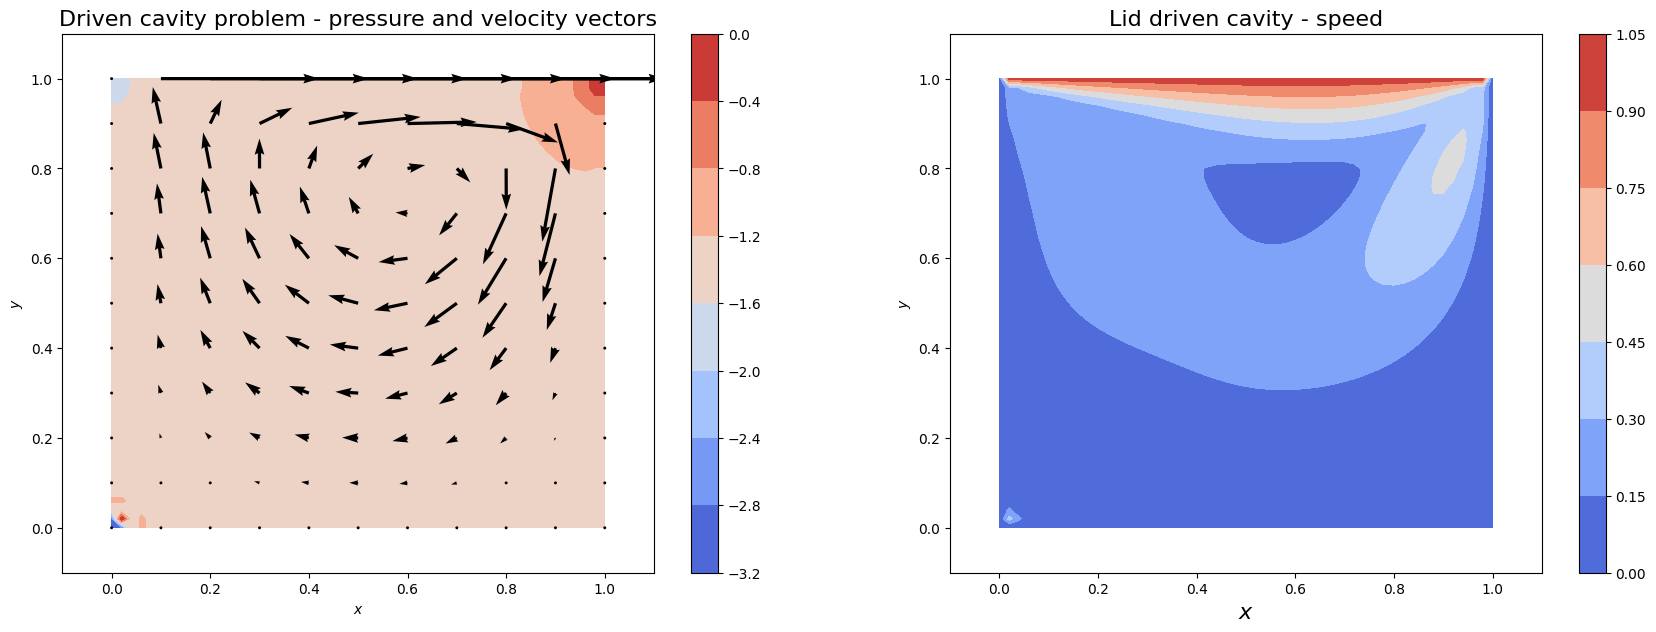

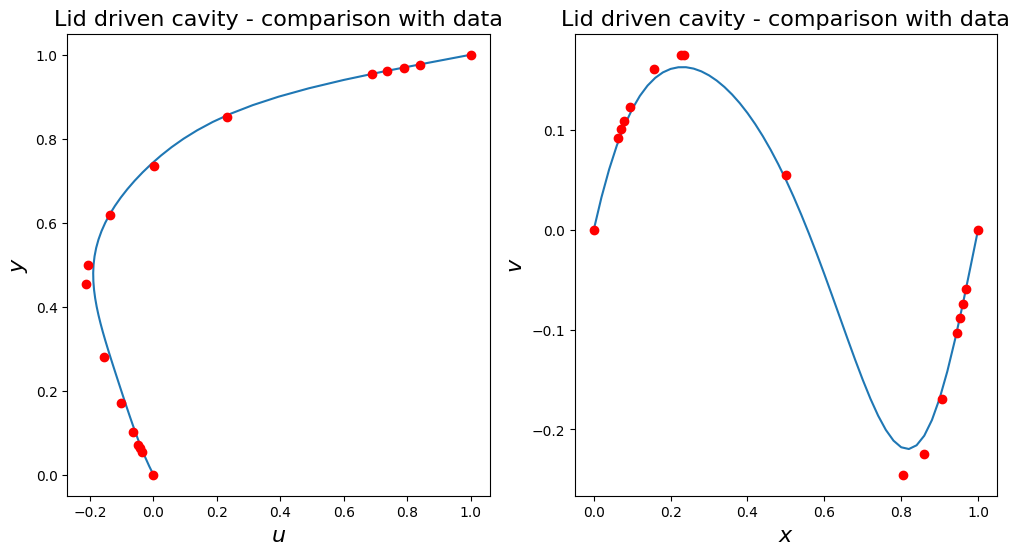

In [10]:
# set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X,Y,p, cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.quiver(X[::5,::5],Y[::5,::5],u[::5,::5],v[::5,::5])
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_title('Driven cavity problem - pressure and velocity vectors', fontsize=16)

ax1 = fig.add_subplot(122)
cont = ax1.contourf(X,Y,np.sqrt(u*u+v*v), cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$')
ax1.set_title('Lid driven cavity - speed', fontsize=16)


fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.plot(u[int(np.shape(u)[0]/2),:],Y[int(np.shape(u)[0]/2),:])
ax1.plot(Ghia_Re100_u[:,1],Ghia_Re100_u[:,0],'ro')
ax1.set_xlabel('$u$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Lid driven cavity - comparison with data', fontsize=16)
ax1 = fig.add_subplot(122)
ax1.plot(X[:,int(np.shape(u)[0]/2)],v[:,int(np.shape(u)[0]/2)])
ax1.plot(Ghia_Re100_v[:,0],Ghia_Re100_v[:,1],'ro')
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$v$', fontsize=16)
ax1.set_title('Lid driven cavity - comparison with data', fontsize=16)

